# F20AA Applied Text Analytics: Coursework 2

In [1]:
# %pip install nltk
# %pip install pandarallel

In [1]:
import pickle
import bz2

import matplotlib.pyplot as plt
import pandas as pd

# preprocessing
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag, pos_tag_sents
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

import sklearn.metrics
from sklearn.model_selection import train_test_split

# optimization
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alora\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alora\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.   Data Exploration and Visualization

In [3]:
# saving data in a pickle file
""" Train.csv exceeds file size limit on GitHub """

# data = pd.read_csv("Train.csv")
# with bz2.BZ2File("train.pickle", "wb") as f:
#     pickle.dump(data, f)
#     f.close()

' Train.csv exceeds file size limit on GitHub '

In [2]:
# loading data from pickle
with bz2.BZ2File("train.pickle", "rb") as f:
    train = pickle.load(f)
    f.close()

In [5]:
train.head()

,overall,Review
0,5,This a really cool (but time-tested) design. T...
1,5,I liked the first pair so well I bought severa...
2,4,I took them to the range to put them to the te...
3,5,What can you say about a yoga block? These ar...
4,5,After reading many reviews I decided on this l...


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222243 entries, 0 to 222242
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   overall  222243 non-null  int64 
 1   Review   222243 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [7]:
train.describe()

,overall
count,222243.000000
mean,4.394771
std,0.985039
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


These tables give us the initial information we need about the dataset - it has two columns, 'overall' which is like a likert scale between 1-5 and is to be used for multiclass classification, and 'Review' which adds onto 'overall' and is a brief subjective opinion of the reviewer on the product. There are only two columns and no missing values, therefore no direct modification needs to be done to the dataset other than preprocessing.

**For explanation purposes, 1-2 will be assumed as negative, 3 as neutral, and 4-5 as positive reviews.**

### Distribution of data

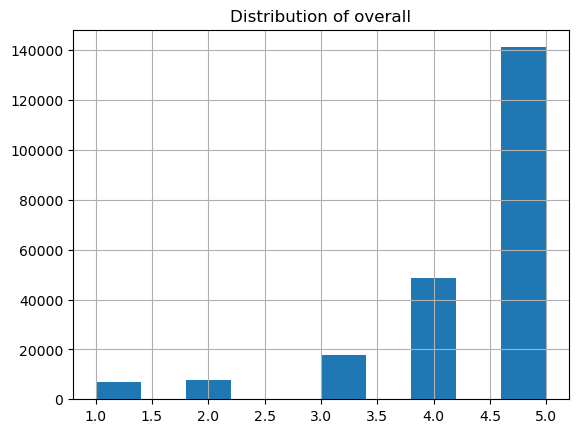

In [8]:
# distribution of overall
train.hist()
plt.title("Distribution of overall")
plt.show()

In [9]:
train['overall'].value_counts()

5    141169
4     48748
3     17947
2      7650
1      6729
Name: overall, dtype: int64

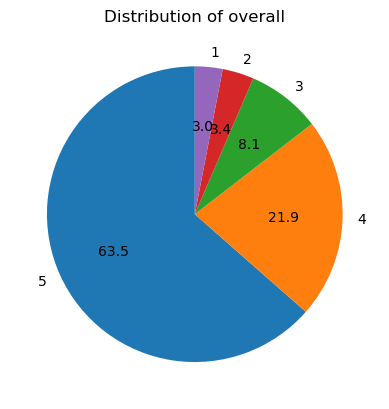

In [10]:
count = train['overall'].value_counts()
plt.pie(count, labels=count.index, autopct="%1.1f", startangle=90)
plt.title("Distribution of overall")
plt.show()

The graphs show that this dataset is extremely unbalanced, with most of the data (~85%) in "classes" 4 and 5. This can prove challenging for our future text classifier, especially for a multi-classification task, as the model may be biased towards the class with the most data and will result to overfitting and inaccurate classification.

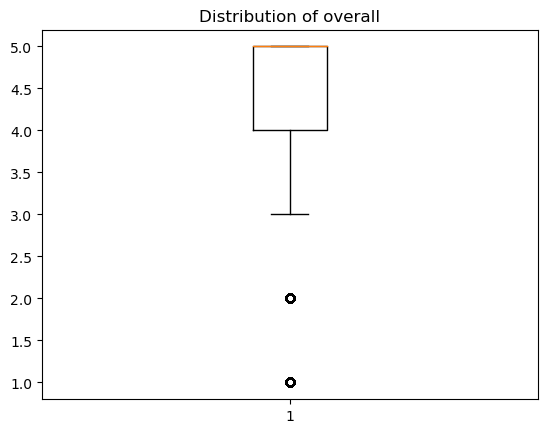

In [11]:
plt.boxplot(train['overall'])
plt.title("Distribution of overall")
plt.show()

A box plot is extremely helpful as it can help us detect any outliers. Here, the plot has marked the minimum and maximum values as 3 and 5 respectively, with most of the data concentrated in classes 4 and 5. As expected, 5 has also been marked as the median as it is the class with the most data. Classes 1 and 2 have been considered as outliers. In most cases, outliers can and should be removed to make sure the classification process can run smoothly and avoid any miss classifications. But, as classes 1 and 2 are the only "negative" classes in this dataset, these outliers cannot be removed, otherwise the data and classifier will render useless.

### Text data

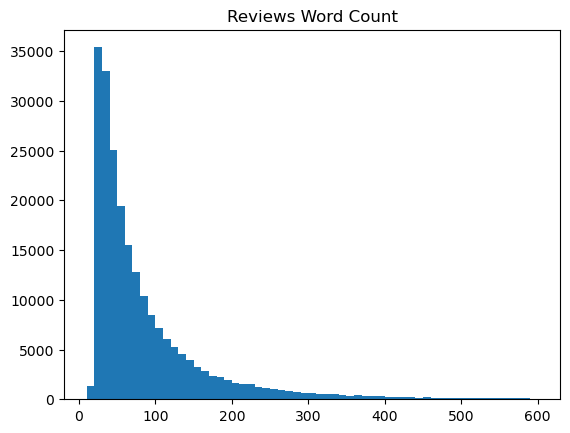

In [12]:
# checking word count
train['Word Count'] = [len(i.split()) for i in list(train['Review'])]

plt.hist(train['Word Count'], bins = range(10, 601, 10))
plt.title("Reviews Word Count")
plt.show()

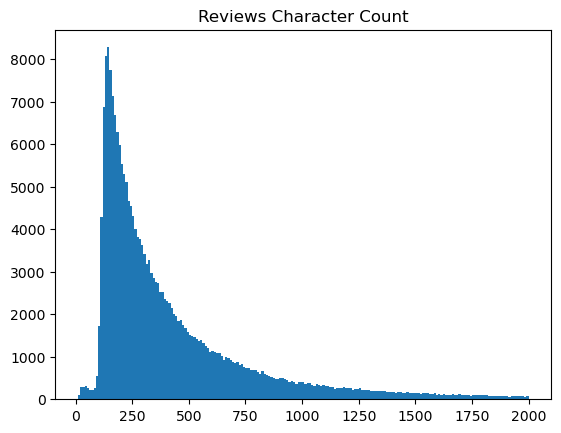

In [13]:
# checking character count
train['Character Count'] = [len(i) for i in list(train['Review'])]

plt.hist(train['Character Count'], bins = range(10, 2001, 10))
plt.title("Reviews Character Count")
plt.show()

Most reviews seem to be short - approx. under 100 words and 500 characters.

### Checking for correlation

In [14]:
train.corr(numeric_only=True)

,overall,Word Count,Character Count
overall,1.000000,-0.072247,-0.069287
Word Count,-0.072247,1.000000,0.997638
Character Count,-0.069287,0.997638,1.000000


Sadly, word and character count seem to have no correlation with the overall scale, therefore these counts will not provide help with classification.

# Text Processing and Normalization

### Making it lowercase

In [3]:
train['Cleaned Reviews'] = train['Review'].parallel_apply(lambda x: " ".join(x.lower() for x in x.split()))

### Removing punctuation and numbers

In [4]:
train['Cleaned Reviews'] = train['Cleaned Reviews'].str.replace('[^\w\s]|[0-9]+','', regex=True)

In [5]:
train['Cleaned Reviews'].head()

0    this a really cool but timetested design the c...
1    i liked the first pair so well i bought severa...
2    i took them to the range to put them to the te...
3    what can you say about a yoga block these are ...
4    after reading many reviews i decided on this l...
Name: Cleaned Reviews, dtype: object

### Removing stopwords

In [6]:
stopw = set(stopwords.words('english'))

In [7]:

train['Cleaned Reviews'] = train['Cleaned Reviews'].apply(lambda rev: " ".join([str for str in rev.split(' ') if str not in stopw]) )

In [8]:
train['Cleaned Reviews'].head()

0    really cool timetested design carbon steel bla...
1    liked first pair well bought several found usu...
2    took range put test adjust volume hear people ...
3    say yoga block solid sturdy  namebrand feared ...
4    reading many reviews decided light satisfied d...
Name: Cleaned Reviews, dtype: object

### Splitting into tokens

Tokenizing is the method of splitting up a corpus into 'tokens' - usually achieved by spltting the text into individual components.

In [9]:
train['Tokenized Reviews'] = train['Cleaned Reviews'].parallel_apply(word_tokenize)

In [10]:
train['Tokenized Reviews'].head()

0    [really, cool, timetested, design, carbon, ste...
1    [liked, first, pair, well, bought, several, fo...
2    [took, range, put, test, adjust, volume, hear,...
3    [say, yoga, block, solid, sturdy, namebrand, f...
4    [reading, many, reviews, decided, light, satis...
Name: Tokenized Reviews, dtype: object

The next step is to lemmatize the tokens, however...

In [11]:
wnl = WordNetLemmatizer()
print(wnl.lemmatize('liked'))

liked


By default, NLTK's WordNetLemmatizer assumes every word is a noun and will lemmatize text incorrectly if POS-tagging (Parts-Of-Speech Tagging) is not done beforehand.

Source: https://www.nltk.org/api/nltk.stem.wordnet.html?highlight=lemmatiz#nltk.stem.wordnet.WordNetLemmatizer.lemmatize

In [12]:
train['Tagged Reviews'] = train['Tokenized Reviews'].parallel_apply(pos_tag)

However, the POS-tag given by NLTK's POS tagger is not an accepted format for NLTK's WordNetLemmatizer, so it needs to be mapped.

In [13]:
# From https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python/15590384#15590384

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def wordnet_format(text):
    return [(word[0],get_wordnet_pos(word[1])) for word in text]


train['Tagged Reviews'] = train['Tagged Reviews'].apply(wordnet_format)

In [14]:
example1 = train['Tokenized Reviews'].iloc[1].copy()
example1pos = train['Tagged Reviews'].iloc[1].copy()

print("Without POS-tag:")
print([wnl.lemmatize(word) for word in example1[:5]])
print("With POS-tag: ")
print([wnl.lemmatize(word[0], pos=word[1]) for word in example1pos[:5]])

Without POS-tag:
['liked', 'first', 'pair', 'well', 'bought']
With POS-tag: 
['like', 'first', 'pair', 'well', 'buy']


As shown above, without POS-tagging, NLTK's lemmatizer doesn't correctly lemmatize verbs. Now that the text has been tokenized and POS-tagged, it can be lemmatized.

### Lemmatizing the tokens

Lemmatization is a text normalization technique used throughout NLP models. Oftentimes, it is the preferred normalization method over stemming, shown by SpaCy opting to drop stemming from its library entirely. 

In [15]:
train['Lemmatized Reviews'] = train['Tagged Reviews'].apply(lambda x: [wnl.lemmatize(word[0], pos=word[1]) if word[1] is not None else wnl.lemmatize(word[0]) for word in x ])
train['Lemmatized Reviews'].head()

0    [really, cool, timetested, design, carbon, ste...
1    [like, first, pair, well, buy, several, find, ...
2    [take, range, put, test, adjust, volume, hear,...
3    [say, yoga, block, solid, sturdy, namebrand, f...
4    [read, many, review, decide, light, satisfied,...
Name: Lemmatized Reviews, dtype: object

### Stemming the tokens

In [18]:
stem = PorterStemmer()
train['Stemmed Reviews'] = train['Tokenized Reviews'].apply(
    lambda rev: [stem.stem(text) for text in rev])
train['Stemmed Reviews'].head()

0    [realli, cool, timetest, design, carbon, steel...
1    [like, first, pair, well, bought, sever, found...
2    [took, rang, put, test, adjust, volum, hear, p...
3    [say, yoga, block, solid, sturdi, namebrand, f...
4    [read, mani, review, decid, light, satisfi, da...
Name: Stemmed Reviews, dtype: object

In [19]:
train.to_pickle('preproc.pkl')

### Evaluating Stemming vs Lemmatization

To evaluate which would perform better, stemming and lemmatization will be compared on their performance on a variety of text representation using a baseline classifier, logistic regression.

### Stemming

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
strings_Stemmed = train["Stemmed Reviews"].map(' '.join)

# Using Bag of Words, we represent the stemmed strings
bow_converter = CountVectorizer(tokenizer=lambda doc: doc)
x_bow = bow_converter.fit_transform(strings_Stemmed)


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [21]:
# Using ngrams 
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc,
ngram_range=(2,2))
x_bigram = bigram_converter.fit_transform(strings_Stemmed)
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc,
ngram_range=(3,3))
x_trigram = trigram_converter.fit_transform(strings_Stemmed)


KeyboardInterrupt: 

In [ ]:
#Using tf-idf
tfidf_vectorizer = TfidfVectorizer()
doc_vec = tfidf_vectorizer.fit_transform(strings_Stemmed)

In [22]:
from sklearn.linear_model import LogisticRegression
Y = train['overall']

def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

def splitclassify(x, type):
    train_X, test_X, train_y, test_y = train_test_split(x, Y, random_state=50)
    simple_logistic_classify(train_X, train_y, test_X, test_y, type)

In [ ]:
splitclassify(x_bow, "BOW")
splitclassify(x_bigram, "bigram")
splitclassify(x_trigram, "trigram")
splitclassify(doc_vec, "tfidf")


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with BOW features 0.6331959467972139


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with bigram features 0.6479365022227822


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with trigram features 0.6834650204279981
Test Score with tfidf features 0.6963157610554166


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Lemmatizing

In [23]:
strings_lemma = train["Lemmatized Reviews"].map(' '.join)

# Using Bag of Words, we represent the stemmed strings
bow_converter = CountVectorizer(tokenizer=lambda doc: doc)
x_bow = bow_converter.fit_transform(strings_lemma)

In [24]:
# Using ngrams 
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc,
ngram_range=(2,2))
x_bigram = bigram_converter.fit_transform(strings_lemma)
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc,
ngram_range=(3,3))
x_trigram = trigram_converter.fit_transform(strings_lemma)

In [25]:
#Using tf-idf
tfidf_vectorizer = TfidfVectorizer()
doc_vec = tfidf_vectorizer.fit_transform(strings_lemma)

In [26]:
splitclassify(x_bow, "BOW")
splitclassify(x_bigram, "bigram")
splitclassify(x_trigram, "trigram")
splitclassify(doc_vec, "tfidf")

c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with BOW features 0.6322420402800526


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with bigram features 0.6465686362736451


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with trigram features 0.6828170839257752


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with tfidf features 0.6929500908910927


### Results

| Text Representation | Stemming Score | Lemmatizing Score |
|---------------------|----------------|-------------------|
| BOW | 0.6332 |0.6322|
|Bigrams |0.6479|0.6466|
|Trigrams|0.6835|0.6828|
|Tf-idf|0.6963|0.6930|

Though the performance is very similar, it can be observed that stemming outperforms lemmatization by 0.0015 on average. This difference is negligible however, and it can be concluded that the normalization technique does not vary performance as much as the text representation technique and classification technique does. 

# Vector Space Model and Feature Representation

As stated by Michael Kana, PhD, in [1], the following text representations techniques are the most common:
- 1-hot encoding
- N-grams
- Bag-of-Words
- TF-IDF
- Word2Vec
- GloVe

Such representation techniques will be experimented with in this section.

[1] https://towardsdatascience.com/representing-text-in-natural-language-processing-1eead30e57d8


In [ ]:
train

In [ ]:
# reducing space
train = train[['Lemmatized Reviews', 'overall']]

In [ ]:
X = train['Lemmatized Reviews']
y = train.overall

In [ ]:
# Imports

# for representation/classification
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# representation
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
import gensim
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier


In [ ]:
def vectorize_sentence_2(sentences, wv_model, mode=0):
    """Convert a list of sentences to a vectors.

    By summing word vectors in the sentence.
    Another option could be to average word vectors rather than just sum.

    Arg: 
        sentence (pd.Series): Series consisting of list of tokenized texts 
        mode (int, 1 or 0): 0 for summing word vectors, 1 or averaging word vectors.
    Returns:
        (np.ndarray): Vector representation of sentences
    """
    if mode not in [0, 1]:
        raise Exception("Mode parameter should be either 1 or 0")

    vector_size = wv_model.vector_size
    count = 1
    vector_sentences = []

    for i in range(len(sentences)):
        sentence = np.zeros(vector_size)
        for word in sentences[i]:
            if word in wv_model:
                count += 1
                sentence += wv_model[word]
        if mode:  # if mode set to 1 (average word vectors)
            sentence = sentence/count
        vector_sentences.append(sentence)
    vector_sentences_df = pd.DataFrame(vector_sentences)
    return vector_sentences_df

In [ ]:
def normalize_vectors(input_vectors):
    """Normalizes vectors to be in range [0,1)

    Args:
        input_vectors (np.ndarray): List of vectors, each vector is np.ndarray
    """

    return MinMaxScaler().fit(input_vectors).transform(input_vectors)

### Link to the GloVe model vectors
Download glove.6B.50d.txt in the glove.6B.zip folder
https://nlp.stanford.edu/projects/glove/


In [ ]:
def get_glove_word_embeddings(): 
    """Gets the words and their vector representations trained from the Glove Model
    
    Code from https://thinkingneuron.com/transfer-learning-with-glove/
    """

    GloveWordVectors = {}
    with open("glove.6B.50d.txt", 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], "float")
            GloveWordVectors[word] = vector
    return GloveWordVectors

## Creating Classes to encapsulate the Glove and Word2Vec models

To be able to use in Pipeline object

In [ ]:
class GloveModel():
    """Implements GloVe vector dictionary as class with same methods as Word2Vec model.
    
    Does this so that helper method vectorize_sentence_2 can be used for glove word embeddings, which is stored as a dictionary.
    """
    def __init__(self, vector_size, word_vector_dict) -> None:
        self.vector_size = vector_size
        self.dictionary = word_vector_dict
    
    def __getitem__(self, key):
        return self.dictionary[key]

In [ ]:


class Vector_Transformer(BaseEstimator, TransformerMixin):
    """ Creates transformer object so that Word2Vec and GloVe models can be used in Pipeline object.
                
    """
    def __init__(self, model, mode:int=0):
        """Creates a Tranformer object for an pre-trained Word Embedding model (Glove or Word2Vec)
        
        """
        self.mode = mode
        self.model = model # Google model, GloVe model

    def fit(self, X, y=None):
        """No fitting needed"""
        return self

    def transform(self, X, y=None):
        """Transforms input text into vectors, then normalized vectors to be in range [0,1)
        
        Args: 
            X (np.ndarray): The preprocessed, tokenized list of sentences

        """ 
        w2v_data = vectorize_sentence_2(X, self.model, mode=self.mode)
        X_w2v_scaled = normalize_vectors(w2v_data.values)

        return X_w2v_scaled

## Loading the Glove and Word2Vec (Google) models

Google Model download: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g

In [ ]:
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('/mnt/d/Andrea/Heriot-Watt/year-4/f20aa/f20aa-coursework-1/GoogleNews-vectors-negative300.bin', binary=True)


In [ ]:
Glove_Model = GloveModel(vector_size=50, word_vector_dict=get_glove_word_embeddings())

## Preparing parameters of the text representations and classifiers for gridsearch

In [ ]:

text_reps = {
    'bow': CountVectorizer(
        preprocessor= lambda x: x, # override preprocessor
        tokenizer= lambda x: x  # override tokenization
    ),
    'tfidf': TfidfVectorizer(
        preprocessor= lambda x: x, # override preprocessor
        tokenizer= lambda x: x  # override tokenization
    ),
    'w2v': Vector_Transformer(GoogleModel), # Word 2 Vec model
    'glove': Vector_Transformer(Glove_Model) # GloVe Model
}

classifiers = {
    'nb': MultinomialNB(),
    'sgd': SGDClassifier()
}

params = {
    # bag of ngrams
    'bow':{
        'countvectorizer__ngram_range': [(a, b) for a in np.arange(1, 5) for b in np.arange(1, 5) if a <= b],
    },
    # tdfidf ngrams
    'tfidf': {
        'tfidfvectorizer__ngram_range':[(a, b) for a in np.arange(1, 5) for b in np.arange(1, 5) if a <= b],
    },
    # pre-trained word2vec
    'w2v': {
        'vector_transformer__mode': [0,1],
    },
    # pre-trained glove
    'glove': {
        'vector_transformer__mode': [0,1],
    },
    # classifiers
    'nb': {
        'multinomialnb__alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    },
    'sgd': {
        "sgdclassifier__loss": ["hinge", "log_loss"],
        "sgdclassifier__alpha": [0.0001, 0.001, 0.01, 0.1],
        "sgdclassifier__penalty": ["l2", "l1", "elasticnet", "none"],
    }
}




## Splitting the gridsearch into 2 rounds

The first gridsearch will test a subset of the text representations with all the classifiers, while the second will test the rest of the text representations with all the classifiers. This is to reduce computational load.


In [ ]:
text_reps_1 = {
    'glove': Vector_Transformer(Glove_Model), # GloVe Model
    'bow': CountVectorizer(
        preprocessor= lambda x: x, # override preprocessor
        tokenizer= lambda x: x  # override tokenization
    ),
    
}

text_reps_2 = {
    'tfidf': TfidfVectorizer(
        preprocessor= lambda x: x, # override preprocessor
        tokenizer= lambda x: x  # override tokenization
    ),
    'w2v': Vector_Transformer(GoogleModel), # Word 2 Vec model
}


In [ ]:

scores_1 = []

for text_rep, text_rep_obj in text_reps_1.items():
    for classifier, classifier_obj  in classifiers.items():
        print(classifier, text_rep)
        pipe = make_pipeline(text_rep_obj, classifier_obj)
        print(pipe)
        grid_search = GridSearchCV(estimator=pipe, param_grid={**params[text_rep], **params[classifier]}, cv=10, scoring='accuracy')
        grid_search.fit(X, y)
        scores_1.append({
            'model': classifier,
            'text_representation': text_rep,
            'scores': grid_search.cv_results_
        })


In [ ]:
with open('scores_1.pkl', 'wb') as f:
    pickle.dump(scores_1, f)

In [ ]:
scores_2 = []

for text_rep, text_rep_obj in text_reps_2.items():
    for classifier, classifier_obj  in classifiers.items():
        print(classifier, text_rep)
        pipe = make_pipeline(text_rep_obj, classifier_obj)
        print(pipe)
        grid_search = GridSearchCV(estimator=pipe, param_grid={**params[text_rep], **params[classifier]}, cv=10, scoring='accuracy')
        grid_search.fit(X, y)
        scores_2.append({
            'model': classifier,
            'text_representation': text_rep,
            'scores': grid_search.cv_results_
        })

In [ ]:
with open('scores_2.pkl', 'wb') as f:
    pickle.dump(scores_2, f)

# FastText Classification

# Topic Modelling

In [9]:
# Required imports
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import math


In [16]:
def plot_top_words(lda, nb_topics, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = plt.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

In [4]:
preprocessed = pd.read_pickle('preproc.pkl')

For topic modelling, people mostly use lemmatization as it preserves the word. (SOURCE) Since stemming can generate words that do not exist, it is difficult to group them into topics.

### Topic Modelling for all reviews

In [ ]:
# Builds a dictionary for each word in lemmatized
review_dict = Dictionary(preprocessed['Lemmatized Reviews'])

# Builds corpus - vectors that represent the occurence of each word 
corpus = [review_dict.doc2bow(review) for review in preprocessed['Lemmatized Reviews']]

Here we evaluate the coherence of topics found. Coherence is a measure of semantic similarity between words and is often used to help decide how many topics there are.

In [ ]:
# Computes coherence
from tqdm import tqdm

review_coherence = []
for nb_topics in tqdm(range(1,20)):
    lda = LdaModel(corpus, num_topics = nb_topics, id2word = review_dict, passes=10)
    cohm = CoherenceModel(model=lda, corpus=corpus, dictionary=review_dict, coherence='u_mass')
    coh = cohm.get_coherence()
    review_coherence.append(coh)



In [ ]:
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,20),review_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

Through the graph, the optimal number of topics should be 5. We use the graph to look for where the average coherence score plateaus, which would be around 3 - 6 topics on our graph.

In [ ]:

k = 5
review_lda = LdaModel(corpus, num_topics = k, id2word = review_dict, passes=10)
  
plot_top_words(review_lda, 5)

From the results, all topics include words such as "like", "great" and "good" which don't add any meaning to the topics, therefore, we will run LDA again, without these words.

In [ ]:
new_stops = ['good', 'great', 'like', 'well']

preprocessed['Adjusted Lemmatized'] = preprocessed['Lemmatized Reviews'].apply(lambda rev : [word for word in rev if word not in new_stops])

In [ ]:
review_dict = Dictionary(preprocessed['Adjusted Lemmatized'])
corpus = [review_dict.doc2bow(review) for review in preprocessed['Adjusted Lemmatized']]

k = 5
reviews_lda = LdaModel(corpus, num_topics = k, id2word = review_dict, passes=10)
  
plot_top_words(reviews_lda, k)

will put analysis here after i run it later

### Topic Modelling for 1 star Reviews

In [8]:
lowstardf= preprocessed[preprocessed['overall'] == 1]
lowstardf.head()

(6729, 7)

In [12]:
# Builds a dictionary for each word in lemmatized
review_dict = Dictionary(lowstardf['Lemmatized Reviews'])

# Builds corpus - vectors that represent the occurence of each word 
corpus = [review_dict.doc2bow(review) for review in lowstardf['Lemmatized Reviews']]

Here, we try to find the optimal number of topics for LDA. Using the same strategy as previously, we evaluate the coherence of various LDA models. 

In [13]:
# Computes coherence
from tqdm import tqdm

review_coherence = []
for nb_topics in tqdm(range(10,20)):
    lda = LdaModel(corpus, num_topics = nb_topics, id2word = review_dict, passes=10)
    cohm = CoherenceModel(model=lda, corpus=corpus, dictionary=review_dict, coherence='u_mass')
    coh = cohm.get_coherence()
    review_coherence.append(coh)

100%|██████████| 10/10 [07:56<00:00, 47.60s/it]


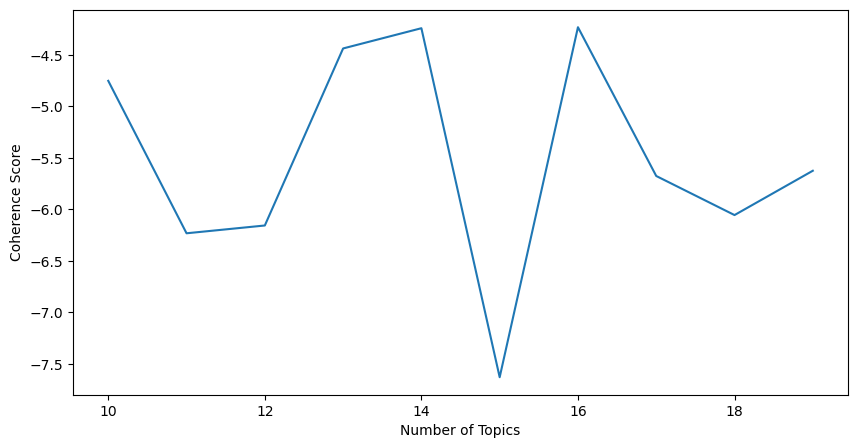

In [14]:
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(10,20),review_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

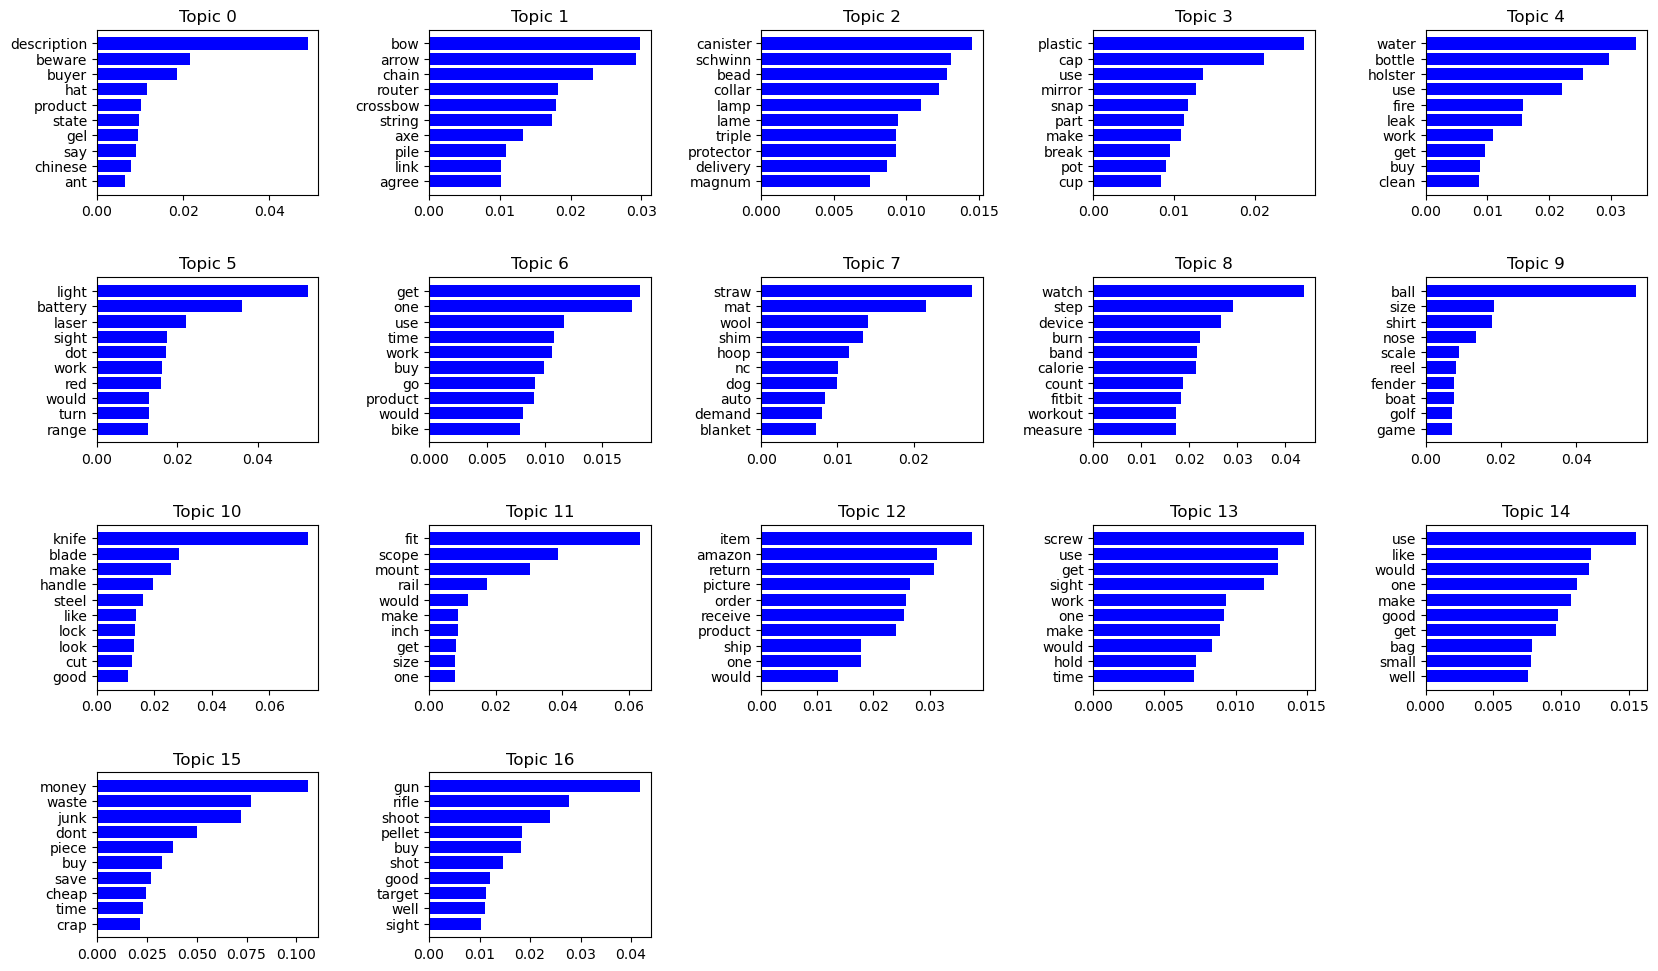

In [18]:
k = 17
low_lda = LdaModel(corpus, num_topics = k, id2word = review_dict, passes=10)
plot_top_words(low_lda, k)

From the topics shown, a general theme across several reviews is the mention of a device like a "knife", "screw", "gun" which implies that a majority of 1 star reviews are centered around items being faulty or misleading - which is implied with "description" being a common word. 

### Topic Modelling for 5 star Reviews


In [11]:
highstardf= preprocessed[preprocessed['overall'] == 5]
highstardf.shape

(141169, 7)

In [ ]:
review_dict = Dictionary(highstardf['Lemmatized Reviews'])
corpus = [review_dict.doc2bow(review) for review in highstardf['Lemmatized Reviews']]

#Using the same number of topics as the 1 star reviews
k = 17
high_lda = LdaModel(corpus, num_topics = k, id2word = review_dict, passes=10)
plot_top_words(high_lda, k)